# CPM Predictor for Ventricular Volume

Adpating code from https://github.com/YaleMRRC/CPM/tree/master (originally meant for ADAS Cog 11 Prediction) for Ventricular Volume Prediction

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, t, ttest_1samp, pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.robust.robust_linear_model import RLM

import json
from joblib import dump

### Get Features (FC Matrices)

In [2]:
ADNI_MERGE_WITH_VENTRICULAR_VOL = '../data/ADNIMERGE_29Apr2024_Ventricles_ICV.csv'

df = pd.read_csv(ADNI_MERGE_WITH_VENTRICULAR_VOL)
df.shape

(1262, 119)

In [3]:
df = df[['RID', 'VISCODE', 'Ventricles_ICV', 'DX', 'DX_bl', 'FC_DATA']]
df = df.dropna(subset=['Ventricles_ICV'])

df.shape

(1262, 6)

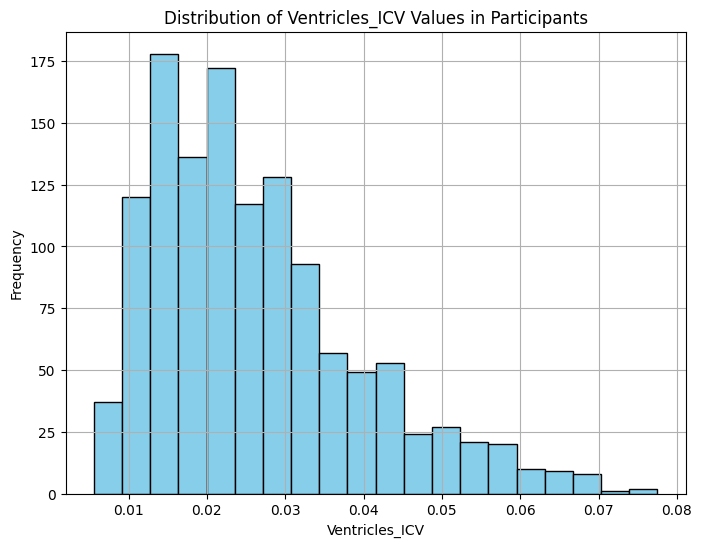

In [4]:
plt.figure(figsize=(8, 6))
plt.hist(df['Ventricles_ICV'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ventricles_ICV Values in Participants')
plt.xlabel('Ventricles_ICV')
plt.ylabel('Frequency')
plt.grid(True)
plt.axis('on')
plt.savefig('../data/ventricles_ICV_dist_20bins.png')

plt.show()

In [5]:
def compute_fc_lower_triangle(fmri, node_size):
    # Calculate the z_score (along the time axis)
    fmri_zscored = (fmri.T - fmri.mean(axis=1)) / fmri.std(axis=1)

    # Calculate the FC 
    fc = np.corrcoef(fmri_zscored.T)
    
    # Get the lower triangle
    mask_e = np.tril_indices(node_size, -1)
    lower_triangle = fc[mask_e]
    
    return lower_triangle

In [6]:
dim_x = len(df)
X = []
NODE_SIZE = 100

for i, file in enumerate(df['FC_DATA'].values[:50]):
    arr = loadmat(f'../{file}')['ROI_activity'][:NODE_SIZE, :] # get the first 100 regions
    fc = compute_fc_lower_triangle(arr, NODE_SIZE)
    X.append(fc)
#     print(fc)
    
X = np.array(X).T
print(X.shape)

Y = df['Ventricles_ICV'][:50]
print(Y.shape)

(4950, 50)
(50,)


In [7]:
def train_cpm(ipmat, pheno, threshold = 0.01):

    """
    Accepts input matrices and pheno data
    Returns model
    @author: David O'Connor
    @documentation: Javid Dadashkarimi
    cpm: in cpm we select the most significant edges for subjects. so each subject
         have a pair set of edges with positive and negative correlation with behavioral subjects.
         It's important to keep both set in final regression task.  
    posedges: positive edges are a set of edges have positive
              correlatin with behavioral measures
    negedges: negative edges are a set of edges have negative
              correlation with behavioral measures
    """
    cc=[spearmanr(pheno,im) for im in ipmat]
    
    rmat=np.array([c[0] for c in cc])
    pmat=np.array([c[1] for c in cc])

    posedges=(rmat > 0) & (pmat < threshold)    # edges correalated with higher scores
    posedges=posedges.astype(int)
    negedges=(rmat < 0) & (pmat < threshold)    # edges correalated with lower scores
    negedges=negedges.astype(int)
    
    pe=ipmat[posedges.astype(bool),:]
    ne=ipmat[negedges.astype(bool),:]
    
    pe=pe.sum(axis=0)/2
    ne=ne.sum(axis=0)/2


    if np.sum(pe) != 0:
        fit_pos=np.polyfit(pe,pheno,1)      # fit a curve through the positive edges
    else:
        fit_pos=[]

    if np.sum(ne) != 0:
        fit_neg=np.polyfit(ne,pheno,1)       # fit a curve through the negative edges
    else:
        fit_neg=[]

    return fit_pos,fit_neg,posedges,negedges

def run_validate(X,y,cvtype,threshold=0.01):
    """
    Accepts input matrices (X), phenotype data (y), and the type of cross-valdiation (cv_type)    
    Returns the R-values for positive model (Rpos), negative model (Rneg), and the combination
    X: the feature matrix of size (number of nodes x number of nodes x number of subjects)
    y: the phenotype vector of size (number of subjects)
    cv_type: the cross-valdiation type, takes one of the followings: 
    1) LOO: leave-one-out cross-validation
    2) 5k: 
    """
    numsubs = len(y)
    
    if cvtype == 'LOO':
        behav_pred_pos=np.zeros([numsubs])
        behav_pred_neg=np.zeros([numsubs])
        for loo in range(0,numsubs):

            print("Running LOO, sub no:",loo)
      
            train_mats=np.delete(X,[loo],axis=1)
            train_pheno=np.delete(y,[loo],axis=0)
            
            test_mat=X[:,loo]
            test_pheno=y[loo]

            pos_fit,neg_fit,posedges,negedges=train_cpm(train_mats,train_pheno,threshold)

            pe=np.sum(test_mat[posedges.flatten().astype(bool)])/2
            ne=np.sum(test_mat[negedges.flatten().astype(bool)])/2
            
            # Run model on test subject

            if len(pos_fit) > 0:
                behav_pred_pos[loo]=pos_fit[0]*pe + pos_fit[1]       # predict using the coefficients of the curve
            else:
                behav_pred_pos[loo]='nan'

            if len(neg_fit) > 0:
                behav_pred_neg[loo]=neg_fit[0]*ne + neg_fit[1]
            else:
                behav_pred_neg[loo]='nan'
          
        return behav_pred_pos, behav_pred_neg
    

In [8]:
results = []

In [9]:
behav_pred_pos, behav_pred_neg = run_validate(X, Y, 'LOO')

Running LOO, sub no: 0
Running LOO, sub no: 1
Running LOO, sub no: 2
Running LOO, sub no: 3
Running LOO, sub no: 4
Running LOO, sub no: 5
Running LOO, sub no: 6
Running LOO, sub no: 7
Running LOO, sub no: 8
Running LOO, sub no: 9
Running LOO, sub no: 10
Running LOO, sub no: 11
Running LOO, sub no: 12
Running LOO, sub no: 13
Running LOO, sub no: 14
Running LOO, sub no: 15
Running LOO, sub no: 16
Running LOO, sub no: 17
Running LOO, sub no: 18
Running LOO, sub no: 19
Running LOO, sub no: 20
Running LOO, sub no: 21
Running LOO, sub no: 22
Running LOO, sub no: 23
Running LOO, sub no: 24
Running LOO, sub no: 25
Running LOO, sub no: 26
Running LOO, sub no: 27
Running LOO, sub no: 28
Running LOO, sub no: 29
Running LOO, sub no: 30
Running LOO, sub no: 31
Running LOO, sub no: 32
Running LOO, sub no: 33
Running LOO, sub no: 34
Running LOO, sub no: 35
Running LOO, sub no: 36
Running LOO, sub no: 37
Running LOO, sub no: 38
Running LOO, sub no: 39
Running LOO, sub no: 40
Running LOO, sub no: 41
Ru

In [16]:
behav_pred_pos

array([0.04017054, 0.04893138, 0.0220012 , 0.02422355, 0.02910874,
       0.01927139, 0.01918364, 0.01989238, 0.02585782, 0.01836053,
       0.01612683, 0.01304881, 0.0138711 , 0.03216921, 0.0193748 ,
       0.01201122, 0.00787349, 0.03112917, 0.02036242, 0.02357893,
       0.02733489, 0.01934004, 0.03272099, 0.01917505, 0.01475983,
       0.01953765, 0.01773441, 0.01353252, 0.01303067, 0.01253816,
       0.00805459, 0.02055851, 0.02403962, 0.02266161, 0.01253262,
       0.01531407, 0.01687227, 0.02445813, 0.02296796, 0.02358054,
       0.02504497, 0.02901036, 0.02717673, 0.02667138, 0.02503069,
       0.02592359, 0.02821735, 0.02521385, 0.02895801, 0.02936384])

In [17]:
Y

0     0.022327
1     0.044713
2     0.020445
3     0.011622
4     0.009847
5     0.010305
6     0.039899
7     0.023155
8     0.022505
9     0.011164
10    0.011294
11    0.011689
12    0.012899
13    0.012176
14    0.013363
15    0.012974
16    0.021365
17    0.022562
18    0.022785
19    0.022817
20    0.023805
21    0.008794
22    0.008961
23    0.014299
24    0.014144
25    0.015393
26    0.010181
27    0.010294
28    0.008804
29    0.009032
30    0.009434
31    0.013180
32    0.014190
33    0.013947
34    0.021928
35    0.021880
36    0.044172
37    0.044157
38    0.026423
39    0.027253
40    0.025005
41    0.064918
42    0.061409
43    0.057665
44    0.057361
45    0.019415
46    0.022724
47    0.023027
48    0.022827
49    0.018072
Name: Ventricles_ICV, dtype: float64

In [12]:
res = {
    'sample_size': 50,
    'p_threshold': 0.01,
    'pearson_r_pos': pearsonr(behav_pred_pos,Y)[0], 
    'pearson_r_neg': pearsonr(behav_pred_neg,Y)[0],
    'spearman_rho_pos': spearmanr(behav_pred_pos,Y)[0], 
    'spearman_rho_neg': spearmanr(behav_pred_neg,Y)[0], 
    'r2_pos': r2_score(behav_pred_pos,Y), 
    'r2_neg': r2_score(behav_pred_neg,Y), 
    'mse_pos': mean_squared_error(behav_pred_pos,Y),
    'mse_neg': mean_squared_error(behav_pred_neg,Y)
}
results.append(res)

In [13]:
res

{'sample_size': 50,
 'p_threshold': 0.01,
 'pearson_r_pos': 0.3706548963362126,
 'pearson_r_neg': 0.07343722671545497,
 'spearman_rho_pos': 0.4245378151260504,
 'spearman_rho_neg': 0.29728691476590635,
 'r2_pos': -2.1109302258482656,
 'r2_neg': -5.0461553882824015,
 'mse_pos': 0.00018465242268902684,
 'mse_neg': 0.0002329877725854676}

In [14]:
# results = [results[1]]
results

[{'sample_size': 50,
  'p_threshold': 0.01,
  'pearson_r_pos': 0.3706548963362126,
  'pearson_r_neg': 0.07343722671545497,
  'spearman_rho_pos': 0.4245378151260504,
  'spearman_rho_neg': 0.29728691476590635,
  'r2_pos': -2.1109302258482656,
  'r2_neg': -5.0461553882824015,
  'mse_pos': 0.00018465242268902684,
  'mse_neg': 0.0002329877725854676}]

In [15]:
results_df = pd.DataFrame(results)
results_df.head()

,sample_size,p_threshold,pearson_r_pos,pearson_r_neg,spearman_rho_pos,spearman_rho_neg,r2_pos,r2_neg,mse_pos,mse_neg
0,50,0.01,0.370655,0.073437,0.424538,0.297287,-2.11093,-5.046155,0.000185,0.000233


In [18]:
results_df.to_csv('cpm_ventricular_icv_exp_2.csv')

Text(0.5, 1.0, 'Ventricular_ICV Scores: Actual vs Predicted')

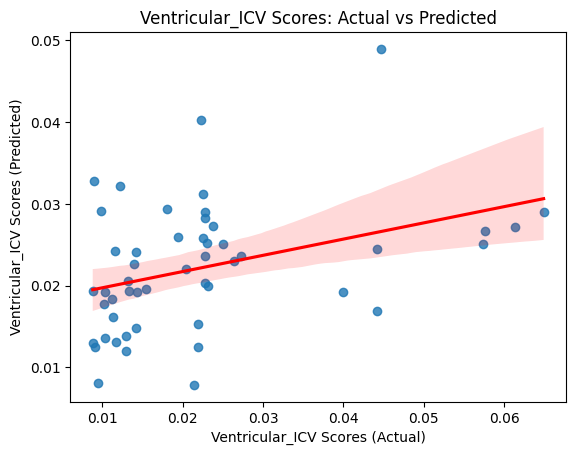

In [22]:
sns.regplot(x=Y, y=behav_pred_pos, line_kws={'color':'red'})
plt.xlabel('Ventricular_ICV Scores (Actual)')  # Replace 'X Axis Label' with the label for your x-axis
plt.ylabel('Ventricular_ICV Scores (Predicted)')  # Replace 'Y Axis Label' with the label for your y-axis
plt.title('Ventricular_ICV Scores: Actual vs Predicted')   # Replace 'Scatter Plot' with the title for your plot